In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-talk')
import numpy as np
import quantbullet.research.jump_model as jm
from quantbullet import set_package_log_level, set_figsize
set_package_log_level('info')

+-------------------------+
|  Package : quantbullet  |
|  Author  : Yiming Zhang |
|  Version : 0.1.0        |
|  Note    : BETA version |
+-------------------------+


## Basic Tutorial

Default parameters can be loaded using `TestingParams` class. This loads the same simulation inputs as the related literature. The transition matrix controls the probability of transitioning from one state to another, and the normal distribution parameters control the mean and standard deviation for each state.

In [2]:
transition_matrix, norm_params = jm.TestingUtils().daily()
print(transition_matrix)
print(norm_params)

[[0.99788413 0.00211587]
 [0.01198743 0.98801257]]
{0: (0.000615, 0.007759155881924271), 1: (-0.000785, 0.017396608864948364)}


The `SimulationGenerator` class runs the simulation by first generating the hidden states, then conditional normal returns.

Here, we observed that simulated returns indeed show pattern of volatility clustering.

09-18 22:57:34 quantbullet.research.jump_model INFO Step 1: Initial (stationary) distribution: [0.84997341 0.15002659]
09-18 22:57:34 quantbullet.research.jump_model INFO Step 2: Simulated states: Counter({0: 633, 1: 368})
09-18 22:57:34 quantbullet.research.jump_model INFO Step 3: Generate simulated return data conditional on states.


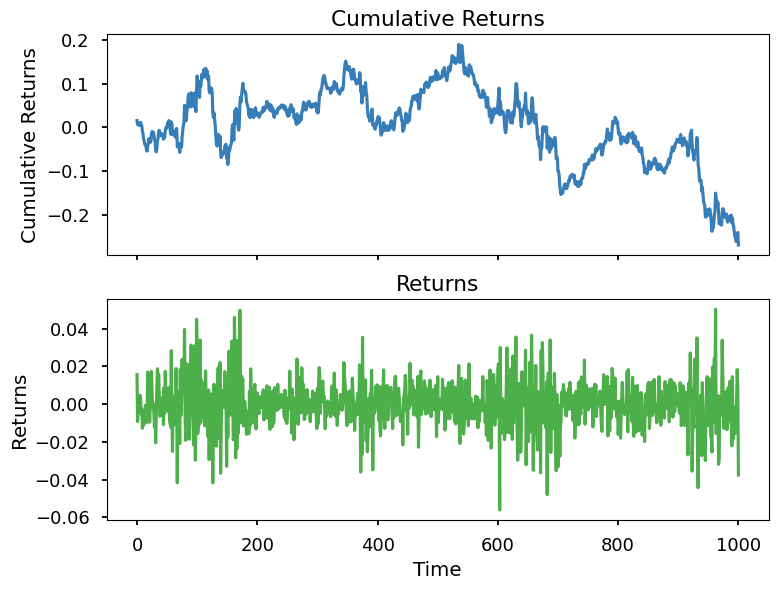

In [3]:
np.random.seed(999)
sim_states, sim_returns = jm.SimulationGenerator().run(
    steps=1000, transition_matrix=transition_matrix, norm_params=norm_params
)
jm.TestingUtils().plot_returns(sim_returns)

To fit the model, `FeatureGenerator` class enriches the features by adding a family of lagged returns and volatility features. It also standardizes the features.

In [4]:
enriched_returns = jm.FeatureGenerator().enrich_features(sim_returns)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)
enriched_returns.shape

(988, 15)

Finally, the dicrete jump model is fitted using `DiscreteJumpModel` class. Lambda is the penalty parameter for the jumps. `n_trials` is the number of trials for different initializations, as the algorithm cannot guarantee to find the global optimum.

09-18 22:57:36 quantbullet.research.jump_model WARNING States identified by volatility ranks and returns ranks are different!
09-18 22:57:36 quantbullet.research.jump_model INFO Mean and Volatility by inferred states:
 {0: (0.04085906653080773, 0.725584534367918), 1: (-0.09106497834644078, 1.4294627297396836)}


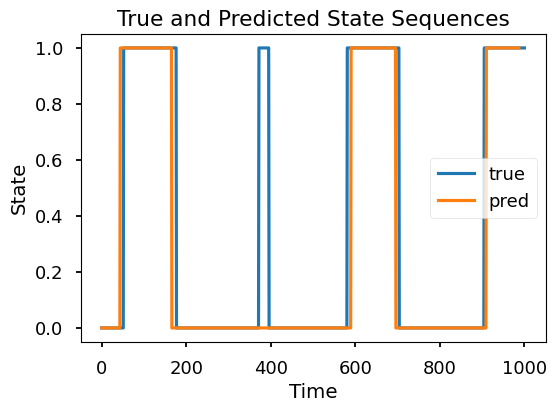

{'BAC': 0.9006048387096774}


In [5]:
model = jm.DiscreteJumpModel()
res = model.fit(enriched_returns, k=2, lambda_=100, rearrange=True, n_trials=4)
with set_figsize(6, 4):
    bac = model.evaluate(sim_states, res['best_state_sequence'], plot=True)

print(bac)

We label the identified states and plot against the returns. The model indeed captures several states with different volatility levels / market downturns.

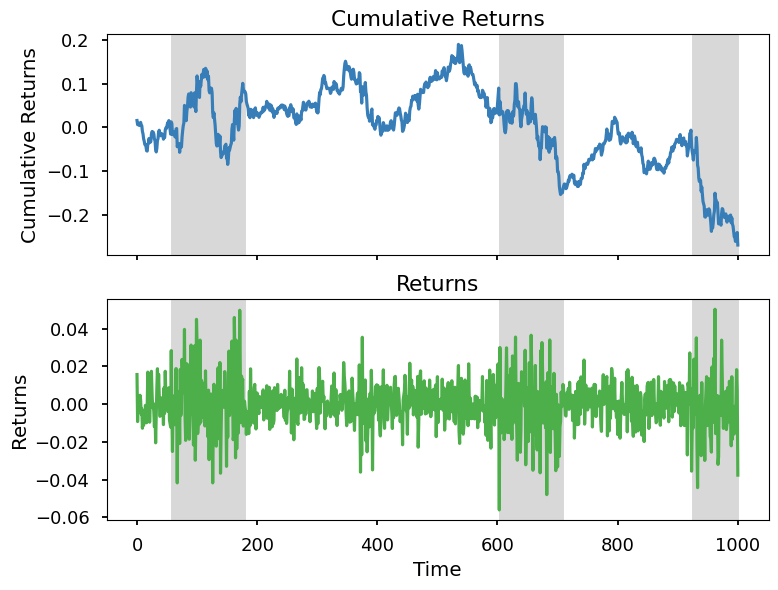

In [6]:
jm.TestingUtils().plot_returns(np.array(sim_returns), res['best_state_sequence'])

## Find the best Penalty parameter

In this section, we aim to find the best penalty parameter for the model. For each penalty parameter, we simulated 50 sequences of states with length 1000, and model runs 8 trials for each sequence. Finally, the average Balanced Accuracy is calculated for each penalty parameter.

In [7]:
from collections import defaultdict
from tqdm import tqdm
import json

bac_lambda_hist = defaultdict(list)
lambda_range = np.logspace(-2, 4, num=13, base=10)
transition_matrix, norm_params = jm.TestingUtils().daily()
model = jm.DiscreteJumpModel()

# for lambda_ in lambda_range:
#     for _ in tqdm(range(50)):
#         sim_states, sim_returns = jm.SimulationGenerator().run(steps=1000, transition_matrix=transition_matrix, norm_params=norm_params)
#         enriched_returns = jm.FeatureGenerator().enrich_features(sim_returns)
#         enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)
#         res = model.fit(enriched_returns, k=2, lambda_=lambda_, rearrange=True, n_trials=8)
#         score = model.evaluate(sim_states, res['best_state_sequence'], plot=False)
#         bac_lambda_hist[str(lambda_)].append(score["BAC"])

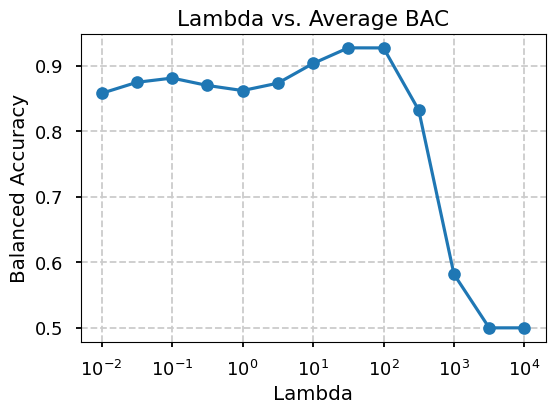

In [8]:
bac_lambda_hist = json.load(open('bac_lambda_hist.json', 'r'))
with set_figsize(6, 4):
    jm.TestingUtils().plot_averages(bac_lambda_hist)